<a href="https://colab.research.google.com/github/balajikulkarni/The-one-with-Deep-Learning/blob/master/CIFAR-10_With_GradCAM_and_CUTOUT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git > /dev/null
!pip install keract > /dev/null

  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-_j2aigxk


In [2]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras import regularizers
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D,AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.layers.pooling import GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.datasets import cifar10
from sklearn.utils import shuffle
from keras.callbacks import ModelCheckpoint
import cv2

Using TensorFlow backend.


In [0]:
def plot_model_history(model_history,clip_beginning=5):
    fig, axs = plt.subplots(1,2,figsize=(18,6))
    # summarize history for accuracy
    acc = model_history.history['acc']
    val_acc = model_history.history['val_acc']
    axs[0].plot(range(clip_beginning+1,len(acc)+1),acc[clip_beginning:])
    axs[0].plot(range(clip_beginning+1,len(val_acc)+1),val_acc[clip_beginning:])
    axs[0].set_title('Model Accuracy: Train = %.3f, Validation = %.3f'%(acc[-1],val_acc[-1]))
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(clip_beginning+1,len(acc)+1),len(acc)/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']
    axs[1].plot(range(clip_beginning+1,len(loss)+1),loss[clip_beginning:])
    axs[1].plot(range(clip_beginning+1,len(val_loss)+1),val_loss[clip_beginning:])
    axs[1].set_title('Model Loss: Train = %.3f, Validation = %.3f'%(loss[-1],val_loss[-1]))
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(clip_beginning+1,len(loss)+1),len(loss)/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
# Define the model
def build_model(lr=0.01):
  
  inp = Input(shape=(32,32,3))
  
  x = Convolution2D(32, (3,3), activation ='relu', kernel_regularizer=regularizers.l2(0.0001), border_mode='same', name="conv1")(inp)
  x = BatchNormalization()(x)

  x = Convolution2D(64, (3, 3), activation ='relu', kernel_regularizer=regularizers.l2(0.0001), border_mode='same', name="conv2")(x)
  x = BatchNormalization()(x)

  x = MaxPooling2D(pool_size=(2, 2))(x)
  x = Dropout(0.1)(x)

  x = Convolution2D(32, (1,1))(x)


  x = Convolution2D(64, (3, 3), activation ='relu', kernel_regularizer=regularizers.l2(0.0001),border_mode='same', name="conv3")(x)
  x = BatchNormalization()(x)

  x = Convolution2D(128, (3, 3), activation ='relu', kernel_regularizer=regularizers.l2(0.0001),border_mode='same', name="conv4")(x)
  x = BatchNormalization()(x)

  x = MaxPooling2D(pool_size=(2, 2))(x)
  x = Dropout(0.15)(x)

  x = Convolution2D(32, (1,1))(x)


  x = Convolution2D(128, (3, 3), activation ='relu', kernel_regularizer=regularizers.l2(0.0001),border_mode='same', name="conv5")(x)
  x = BatchNormalization()(x)

  x = Convolution2D(256, (3, 3), activation ='relu', kernel_regularizer=regularizers.l2(0.0001),border_mode='same', name="conv6")(x)
  x = BatchNormalization()(x)

  x = MaxPooling2D(pool_size=(2, 2))(x)
  x = Dropout(0.2)(x)

  x = Convolution2D(10, (1,1), name="conv7")(x)

  x = GlobalAveragePooling2D()(x)
  out = Activation('softmax')(x)

  model = Model(inputs=inp, outputs=out)
  
  sgd = optimizers.SGD(lr=lr, decay=0, momentum=0.9, nesterov=True)
  model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
  return model

In [6]:
model = build_model()
model.summary()

W0801 16:23:43.737118 139907077502848 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0801 16:23:43.786582 139907077502848 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", kernel_regularizer=<keras.reg..., name="conv1", padding="same")`
  """
W0801 16:23:43.796592 139907077502848 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0801 16:23:43.854176 139907077502848 deprecation_w

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
__________

### Total params: 455,370

## **LR Finder**

In [0]:
from matplotlib import pyplot as plt
import math
from keras.callbacks import LambdaCallback
import keras.backend as K
import numpy as np


class LRFinder:
    """
    Plots the change of the loss function of a Keras model when the learning rate is exponentially increasing.
    See for details:
    https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
    """
    def __init__(self, model):
        self.model = model
        self.losses = []
        self.lrs = []
        self.best_loss = 1e9

    def on_batch_end(self, batch, logs):
        # Log the learning rate
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        # Log the loss
        loss = logs['loss']
        self.losses.append(loss)

        # Check whether the loss got too large or NaN
        if batch > 5 and (math.isnan(loss) or loss > self.best_loss * 4):
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        # Increase the learning rate for the next batch
        lr *= self.lr_mult
        K.set_value(self.model.optimizer.lr, lr)

    def find(self, x_train, y_train, start_lr, end_lr, batch_size=64, epochs=1):
        num_batches = epochs * x_train.shape[0] / batch_size
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(num_batches))

        # Save weights into a file
        self.model.save_weights('tmp.h5')

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))

        self.model.fit(x_train, y_train,
                        batch_size=batch_size, epochs=epochs,
                        callbacks=[callback])

        # Restore the weights to the state before model fitting
        self.model.load_weights('tmp.h5')

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)

    def find_generator(self, generator, start_lr, end_lr, test_generator=None, epochs=1, steps_per_epoch=None, **kw_fit):
            if steps_per_epoch is None:
                try:
                    steps_per_epoch = len(generator)
                except (ValueError, NotImplementedError) as e:
                    raise e('`steps_per_epoch=None` is only valid for a'
                            ' generator based on the '
                            '`keras.utils.Sequence`'
                            ' class. Please specify `steps_per_epoch` '
                            'or use the `keras.utils.Sequence` class.')
            self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(steps_per_epoch))

            # Save weights into a file
            self.model.save_weights('tmp.h5')

            # Remember the original learning rate
            original_lr = K.get_value(self.model.optimizer.lr)

            # Set the initial learning rate
            K.set_value(self.model.optimizer.lr, start_lr)

            callback = LambdaCallback(on_batch_end=lambda batch,
                                      logs: self.on_batch_end(batch, logs))

            self.model.fit_generator(generator=generator,
                                     epochs=epochs,
                                     steps_per_epoch=steps_per_epoch,
                                     callbacks=[callback],
                                     **kw_fit)

            # Restore the weights to the state before model fitting
            self.model.load_weights('tmp.h5')

            # Restore the original learning rate
            K.set_value(self.model.optimizer.lr, original_lr)

    def plot_loss(self, n_skip_beginning=10, n_skip_end=5):
        """
        Plots the loss.
        Parameters:
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
        """
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], self.losses[n_skip_beginning:-n_skip_end])
        plt.xscale('log')
        

    def plot_loss_change(self, sma=1, n_skip_beginning=10, n_skip_end=5, y_lim=(-0.01, 0.01)):
        """
        Plots rate of change of the loss function.
        Parameters:
            sma - number of batches for simple moving average to smooth out the curve.
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
            y_lim - limits for the y axis.
        """
        derivatives = self.get_derivatives(sma)[n_skip_beginning:-n_skip_end]
        lrs = self.lrs[n_skip_beginning:-n_skip_end]
        plt.ylabel("rate of loss change")
        plt.xlabel("learning rate (log scale)")
        plt.plot(lrs, derivatives)
        plt.xscale('log')
        plt.ylim(y_lim)

    def get_derivatives(self, sma):
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.lrs)):
            derivatives.append((self.losses[i] - self.losses[i - sma]) / sma)
        return derivatives

    def get_best_lr(self, sma, n_skip_beginning=10, n_skip_end=5):
        derivatives = self.get_derivatives(sma)
        best_der_idx = np.argmax(derivatives[n_skip_beginning:-n_skip_end])[0]
        return self.lrs[n_skip_beginning:-n_skip_end][best_der_idx]

## **CUTOUT**

In [0]:
# Implementing CUTOUT
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [9]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
num_classes = len(np.unique(y_train))
X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)

Y_train = np_utils.to_categorical(y_train, num_classes)
Y_test = np_utils.to_categorical(y_test, num_classes)


datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True, preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=True))
datagen.fit(X_train)
train_iterator = datagen.flow(X_train, Y_train, batch_size=256, shuffle=True)

datagen_validation = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
datagen_validation.fit(X_train)
validation_iterator = datagen_validation.flow(X_test, Y_test, batch_size=512, shuffle=True)

def denormalize(img):
  return (img*datagen_validation.std + datagen_validation.mean)/255

170500096/170498071 [==============================] - 5s 0us/step


## Compile and run the LR finder to get the best LR

In [10]:
model = build_model()
lr_finder = LRFinder(model)

generator = datagen.flow(X_train, Y_train, batch_size=256,shuffle=True)
lr_finder.find_generator(generator, 0.0001, 10, epochs=1, steps_per_epoch=None,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", kernel_regularizer=<keras.reg..., name="conv1", padding="same")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", kernel_regularizer=<keras.reg..., name="conv2", padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", kernel_regularizer=<keras.reg..., name="conv3", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", kernel_regularizer=<keras.reg..., name="conv4", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Up

Epoch 1/1
178/196 [==========================>...] - ETA: 2s - loss: 2.3393 - acc: 0.2677

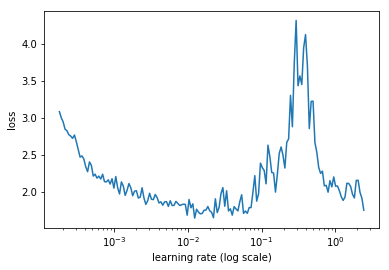

In [11]:
lr_finder.plot_loss()

## Train the network using best LR, CutOut and SGD with momentum

In [0]:
# Run the network to train for 100 epochs

# train the model
model = build_model(lr=0.02)

checkpoint = ModelCheckpoint("Assignment-11.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')

cb = [checkpoint]

model_info = model.fit_generator(train_iterator,
                                 steps_per_epoch = len(train_iterator),
                                 validation_data = validation_iterator, 
                                 validation_steps = len(validation_iterator),
                                 epochs=100, verbose=0, callbacks=cb)

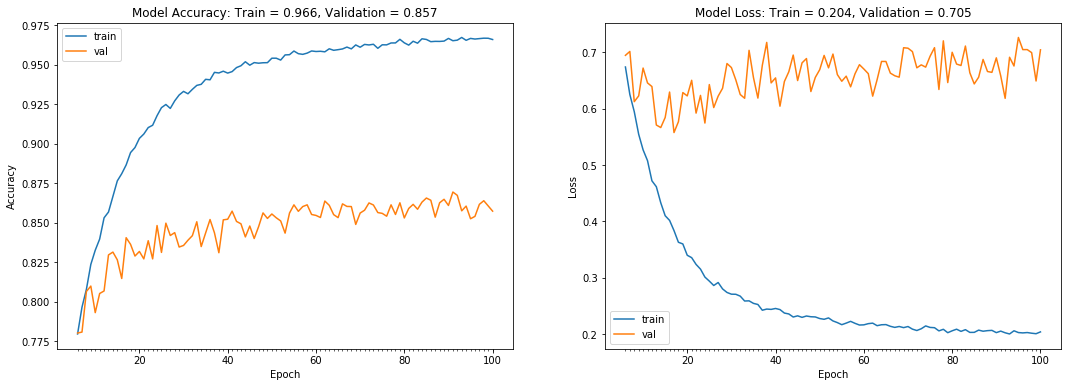

None


In [13]:
print(plot_model_history(model_info))

## Run GradCAM on 25 misclassified images

In [0]:
def min_max_scale(X):
  return (X - np.min(X))/(np.max(X)-np.min(X))

def get_misclassfied_images(X, y_true, y_pred):
  '''
  https://github.com/faizanahemad/data-science-utils/blob/master/data_science_utils/vision/keras/gradcam.py
  '''
  y_true = np.argmax(y_true, axis=1)
  y_pred = np.argmax(y_pred, axis=1)
  
  misclassified = y_true!= y_pred
  X = X[misclassified]
  y_true = y_true[misclassified]
  y_pred = y_pred[misclassified]
  
  return X, y_true, y_pred
  

def get_cifar_labels():
  return ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

def gradCAM(model, img, prediction, label, classes, denormalize_fn=None,preproc_img=min_max_scale):
    class_idx = np.argmax(label, axis=0)
    
    x = np.expand_dims(image.img_to_array(img), axis=0)
    
    if denormalize_fn is not None:
      x = denormalize_fn(x)
    if preproc_img is not None:
      img = preproc_img(img)
    
    class_output = model.output[:, class_idx]
    last_conv_layer = model.get_layer('conv6')
    layer_out_channels = last_conv_layer.output_shape[-1]

    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    
    for i in range(layer_out_channels):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
        
    
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    heatmap = heatmap / 255
    
    superimposed_img = 0.6 * img + 0.4 * heatmap

    
    
    plt.imshow(img)
    plt.show()
    plt.imshow(superimposed_img)
    plt.show()
  

def DisplayMisclassifiedImages(model, samples, test_generator, classes=get_cifar_labels()):
  misclass_images = []
  predictions = []
  labels = []
  
 
  batchX, batchY = test_generator.next()
  predictions = model.predict(batchX)
  X, y_true, y_pred = get_misclassfied_images(batchX, batchY, predictions)
 
  misclass_images = X[:samples]
  labels  = y_true[:samples]
  predictions = y_pred[:samples]
  
  fig = plt.figure(figsize=(3,3))

  for i in range(samples):
    prediction = predictions[i]
    label = labels[i]
    image = misclass_images[i]
    
    gradCAM(model, image, prediction, label, classes)
    
    print("Actual:" + classes[label] + " Predicted:" + classes[prediction])
    ax = plt.Subplot(fig, 111)
    fig.add_subplot(ax)
    
  fig.show()

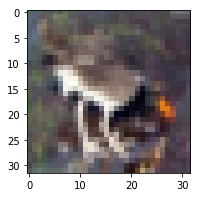

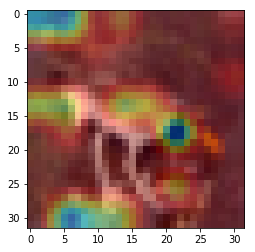

Actual:bird Predicted:frog


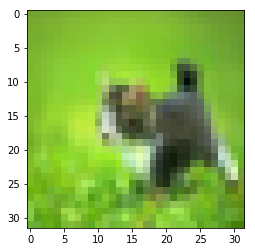

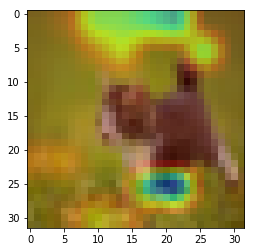

Actual:cat Predicted:bird


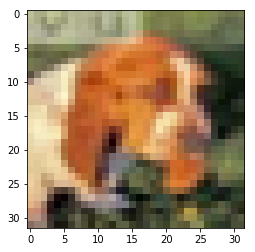

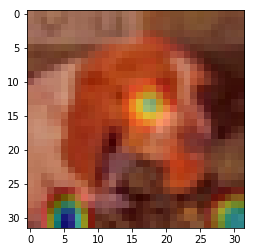

Actual:dog Predicted:cat


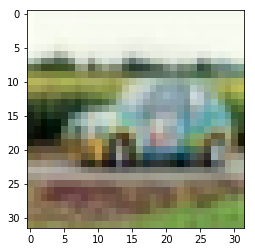

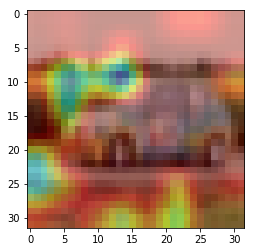

Actual:automobile Predicted:truck


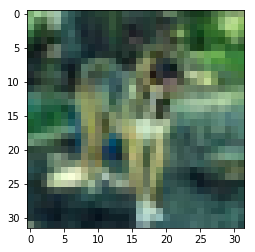

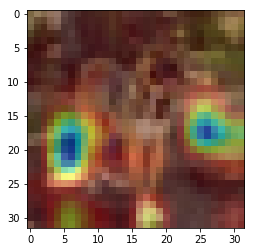

Actual:dog Predicted:cat


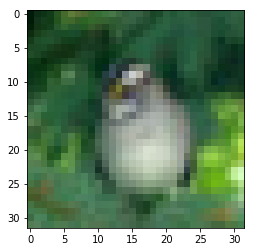

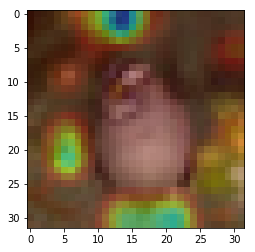

Actual:bird Predicted:cat


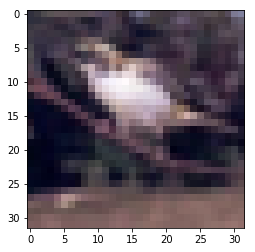

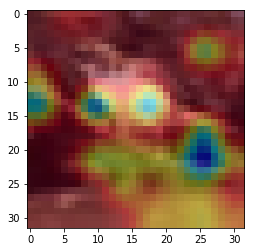

Actual:bird Predicted:airplane


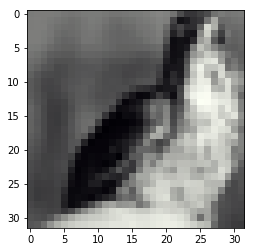

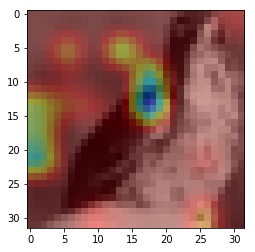

Actual:bird Predicted:cat


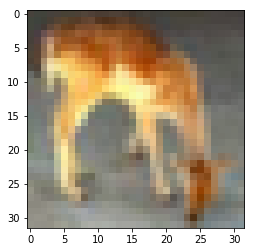

W0801 17:57:45.440484 139907077502848 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


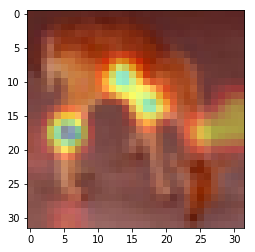

Actual:deer Predicted:dog


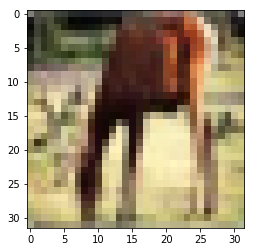

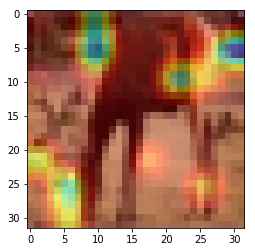

Actual:deer Predicted:horse


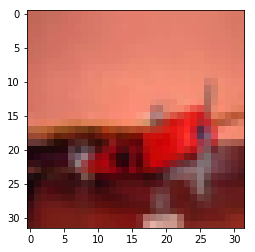

W0801 17:57:47.939793 139907077502848 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


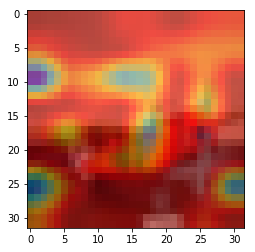

Actual:airplane Predicted:ship


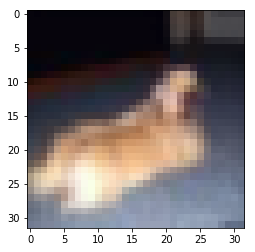

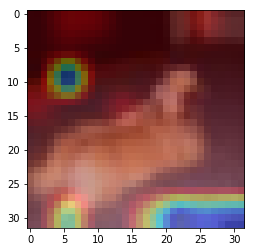

Actual:dog Predicted:cat


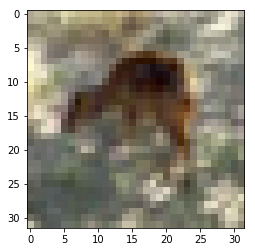

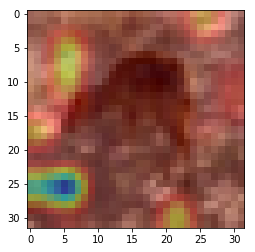

Actual:deer Predicted:frog


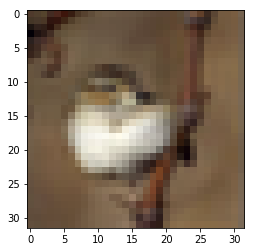

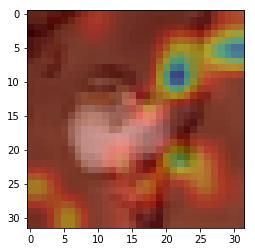

Actual:bird Predicted:cat


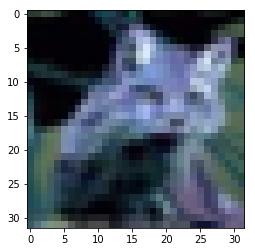

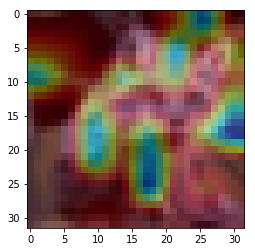

Actual:cat Predicted:horse


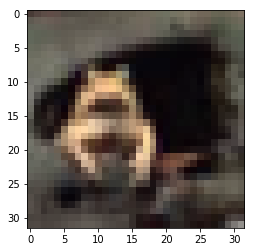

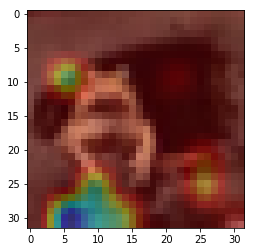

Actual:frog Predicted:cat


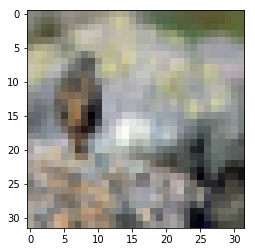

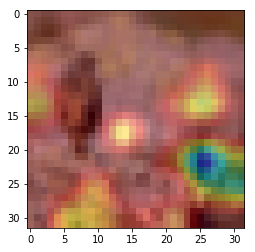

Actual:bird Predicted:frog


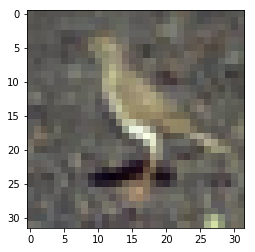

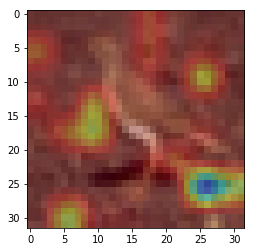

Actual:bird Predicted:frog


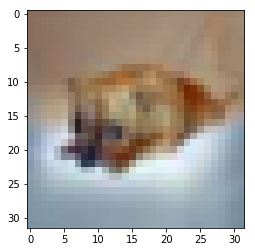

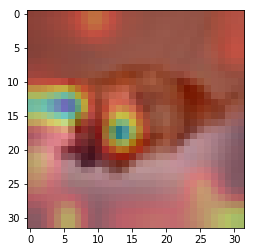

Actual:dog Predicted:frog


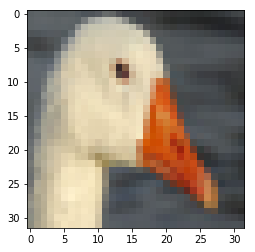

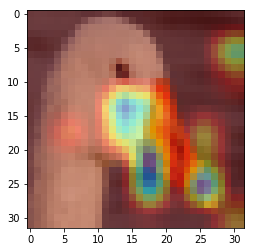

Actual:bird Predicted:dog


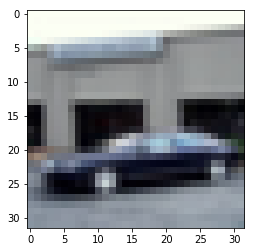

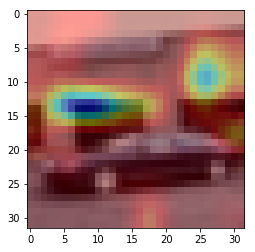

Actual:automobile Predicted:truck


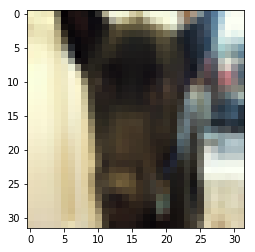

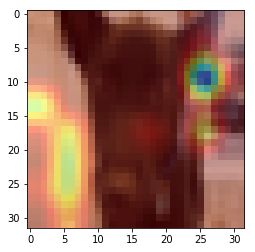

Actual:dog Predicted:cat


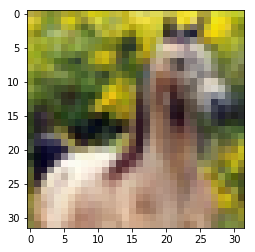

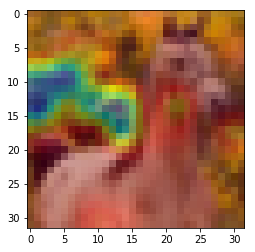

Actual:horse Predicted:cat


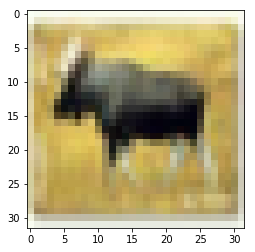

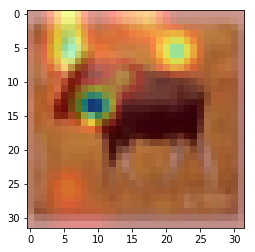

Actual:deer Predicted:horse


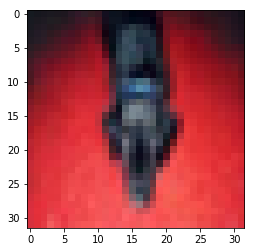

W0801 17:58:06.303091 139907077502848 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


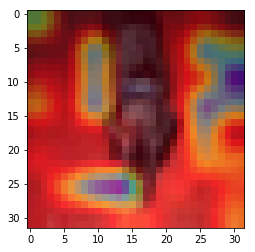

Actual:dog Predicted:cat


In [35]:
DisplayMisclassifiedImages(model, 25, validation_iterator, classes=get_cifar_labels())